In [37]:
import numpy as np
import torch
import networkx as nx

from src.causal_recourse_gen import CausalRecourseGenerationParallel

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


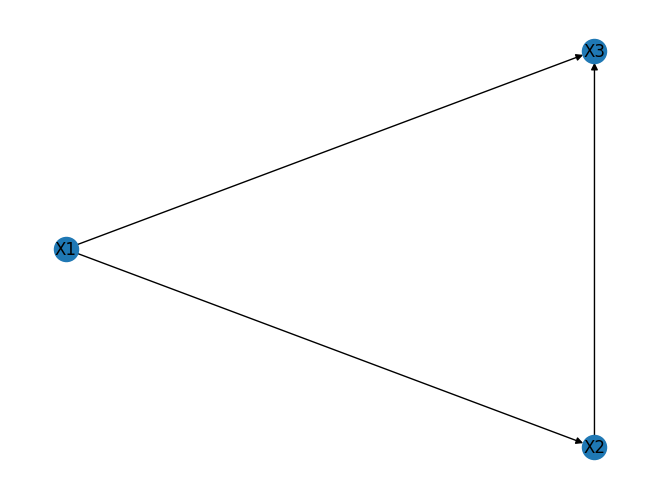

In [120]:
W_adjacency = np.array([[0, 0.3, 0.2], [0, 0, -0.4], [0, 0, 0]])
# draw graph from adjacency matrix
G = nx.from_numpy_array(W_adjacency, create_using=nx.DiGraph)
nx.draw_shell(G, with_labels=True, labels={0: "X1", 1: "X2", 2: "X3"})

In [121]:
W_classifier = np.array([0.5, 0.6, 0.7])
b_classifier = -0.5

In [133]:
X = np.array([[0.2, -0.8, -0.4], [-0.6, -0.9, -0.3]])

In [134]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [135]:
sigmoid(X @ W_classifier + b_classifier)

array([0.23866729, 0.17508627])

In [137]:
# if name is main needed otherwise multiprocessing fails
if __name__ == "__main__":
    recourse_gen = CausalRecourseGenerationParallel(
        learn_beta=False, learn_ordering=False
    )
    recourse_gen.add_data(
        X=torch.tensor(X),
        W_adjacency=torch.tensor(W_adjacency),
        W_classifier=torch.tensor(W_classifier),
        b_classifier=torch.tensor(b_classifier),
    )
    recourse_gen.set_ordering(torch.Tensor([0, 1, 2]))
    recourse_gen.set_beta(torch.Tensor([1, 1, 1]))
    recourse_df = recourse_gen.gen_recourse(classifier_margin=0, max_epochs=2000)

100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


In [138]:
recourse_df

,X1,X2,X3,a1,a2,a3,order1,order2,order3,cost,prob
0,0.953375,-0.279988,0.276200,0.753385,0.294004,0.643133,0.0,1.0,2.0,1.067619,0.500509
1,0.406753,-0.205095,0.603622,1.006760,0.392882,0.859429,0.0,1.0,2.0,1.906513,0.500714


In [147]:
# sample different betas
betas = np.random.uniform(0, 2, (2, 5,3))

In [148]:
for i in range(5):
    beta = betas

array([[0.46445343, 0.38607613, 0.86970296],
       [0.49910637, 0.12452227, 0.61830683],
       [1.25919016, 1.59435807, 0.44701022],
       [0.55383764, 1.82481848, 0.75643119],
       [1.33929246, 1.10398793, 1.65611853]])

In [146]:
for beta in betas:
    recourse_gen.set_beta(torch.tensor(beta, dtype=torch.float32))
    df = recourse_df = recourse_gen.gen_recourse(classifier_margin=0.02, max_epochs=2000)
    print(df)

100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


        X1        X2        X3        a1        a2        a3  order1  order2  \
0  0.70164 -0.507862  0.838523  0.501337  0.141551  1.195225     0.0     1.0   
1 -0.02302 -0.563176  1.221030  0.577017  0.163742  1.471062     0.0     1.0   

   order3      cost      prob  
0     2.0  0.955516  0.533218  
1     2.0  1.381260  0.501326  


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


         X1        X2        X3        a1        a2        a3  order1  order2  \
0  1.178463 -0.263952  0.127409  0.978480  0.242510  0.428721     0.0     1.0   
1  0.702468 -0.186525  0.401920  1.302481  0.322735  0.570520     0.0     1.0   

   order3      cost      prob  
0     2.0  1.207381  0.505011  
1     2.0  2.139009  0.505166  


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


         X1        X2        X3        a1        a2        a3  order1  order2  \
0  1.481964 -0.369899 -0.108013  1.281747  0.045604  0.054023     0.0     1.0   
1  1.096293 -0.333629  0.084114  1.695983  0.057622  0.068182     0.0     1.0   

   order3      cost      prob  
0     2.0  0.103267  0.485862  
1     2.0  0.180257  0.476729  


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


         X1       X2        X3        a1        a2        a3  order1  order2  \
0  0.540272 -0.52459  0.997779  0.340010  0.173201  1.399389     0.0     1.0   
1 -0.151745 -0.53725  1.548471  0.447929  0.228116  1.850530     0.0     1.0   

   order3      cost      prob  
0     2.0  1.047818  0.538381  
1     2.0  1.828653  0.546294  


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

         X1        X2        X3        a1        a2        a3  order1  order2  \
0  0.722283 -0.163410  0.364328  0.522288  0.479912  0.851844     0.0     1.0   
1  0.095297 -0.052339  0.717642  0.695301  0.639077  1.134220     0.0     1.0   

   order3      cost      prob  
0     2.0  1.396864  0.504531  
1     2.0  2.476242  0.504649  


In [192]:
import torch
import torch.optim as optim

# Sample data
N = 100
x_dim = 5
x = torch.randn(N, x_dim, requires_grad=True)
lambdas = torch.zeros(N, requires_grad=True)

def f(x):
    # Sample function: sum of squares for each row
    return torch.sum(x**2, dim=1)

def g(x):
    # Sample constraint: sum of elements for each row should be >= 2
    return 2 - torch.sum(x, dim=1)

min_optimizer = optim.SGD([x], lr=0.1)
max_optimizer = optim.SGD([lambdas], lr=0.1)

costs = []
constraints = []

num_epochs = 10000
losses = []
for epoch in range(num_epochs):

    max_loss = torch.mean((lambdas * g(x)) - f(x))

    max_optimizer.zero_grad()
    max_loss.backward()
    max_optimizer.step()

    min_loss = torch.mean(f(x) - (lambdas * g(x)))
    
    min_optimizer.zero_grad()
    min_loss.backward()
    min_optimizer.step()
    
    costs.append(f(x).mean().detach())
    constraints.append(g(x).mean().detach())
    


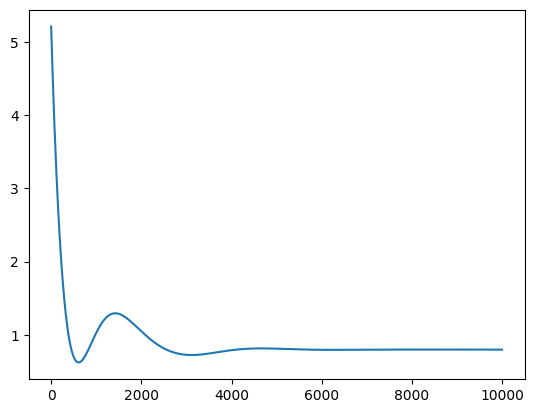

In [193]:
plt.plot(costs)

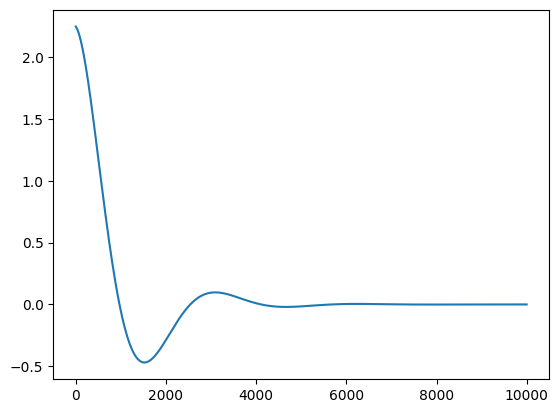

In [194]:
plt.plot(constraints)